# Constraint Docking

This feature is available since version 2.0.0

**NOTE**: Since version 2.1.7 it is not needed to specify `protected_ids` to avoid failures of **MolDrug**. However, on this tutorial we will let the workaround for user with older versions. May be that the specified CReM parameters completely remove any similarity between a solution and the reference structure for constraint docking; only in this specific scenarios you should protect some atoms in order to preserve some MCS.

In [1]:
import tempfile, os, requests, gzip, shutil, yaml
from multiprocessing import cpu_count
from moldrug.data import ligands, boxes, receptor_pdbqt, receptor_pdb, constraintref
from moldrug import utils
tmp_path = tempfile.TemporaryDirectory()
import numpy as np
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from moldrug.utils import Individual
import pandas as pd

In [2]:
# Remember to change to your vina executable
# If you define as a path, it must be absolute
vina_executable = '/Users/klimt/GIT/docking/vina_1.2.5_mac_x86_64'

In [18]:
# This function is possible from version 2.2.0
def plot_dist(individuals:list[utils.Individual], properties:list[str], every_gen:int = 1):

    # Set up the matplotlib figure
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(nrows = len(properties), figsize=(25, 25))

    SawIndividuals = utils.to_dataframe(individuals).drop(['pdbqt'], axis = 1).replace([np.inf, -np.inf], np.nan).dropna()
    SawIndividuals = SawIndividuals[SawIndividuals['kept_gens'].map(len) != 0].reset_index(drop=True)
    gen_idxs = sorted(set(item for sublist in SawIndividuals['kept_gens'] for item in sublist))

    NumGens = max(gen_idxs)

    # Set pop to the initial population and pops out the first gen
    pop = SawIndividuals[SawIndividuals.genID == gen_idxs.pop(0)].sort_values(by=["cost"])
    pops = pop.copy()
    for gen_idx in gen_idxs:
        idx = [i for i in range(SawIndividuals.shape[0]) if gen_idx in SawIndividuals.loc[i,'kept_gens']]
        pop = SawIndividuals.copy().iloc[idx,:].assign(genID=gen_idx)
        pops = pd.concat([pops, pop.copy()])
    # Draw a violinplot with a narrow bandwidth than the default
    pops = pops.loc[pops['genID'].isin([gen for gen in range(0, NumGens+every_gen, every_gen)])]

    if len(properties) <= 1:
        sns.violinplot(hue = 'genID', y = properties[0], data=pops, palette="Set3", bw_adjust=.2, cut=0, linewidth=1, ax=axes, legend=False)
    else:
        for i, prop in enumerate(properties):
            sns.violinplot(x = 'genID', hue = 'genID', y = prop, data=pops, palette="Set3", bw_adjust=.2, cut=0, linewidth=1, ax=axes[i], legend=False)

    return fig, axes

In [4]:
def atom_ids_list(smiles:str) -> list[int]:
    """Return a list of atom IDs for the molecule

    Parameters
    ----------
    smiles : str
        The SMILES string of the molecule

    Returns
    -------
    list[int]
        List of atoms IDs
    """
    return list(range(Chem.MolFromSmiles(smiles).GetNumAtoms()))

In [5]:
# Setting the working directory (you could change it but it MUST be an absolute path)
wd = tmp_path.name
# os.makedirs('wd_tutorial', exist_ok=True)
# wd = os.path.abspath('wd_tutorial')


In [6]:
# Getting the data
lig = ligands.r_x0161
box = boxes.r_x0161
with open(os.path.join(wd, 'x0161.pdbqt'), 'w') as f:
    f.write(receptor_pdbqt.r_x0161)
with open(os.path.join(wd, 'x0161.pdb'), 'w') as f:
    f.write(receptor_pdb.r_x0161)
with open(os.path.join(wd, 'ref.sdf'), 'w') as f:
    f.write(constraintref.r_x0161)
# Getting the CReM data base
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(wd,'crem.db.gz')
crem_db_path = os.path.join(wd,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(lig)
print(atom_ids_list(lig))
print(box)
print(wd, os.listdir(wd))

COC(=O)C=1C=CC(=CC1)S(=O)(=O)N
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
{'A': {'boxcenter': [12.11, 1.84, 23.56], 'boxsize': [22.5, 22.5, 22.5]}}
/var/folders/fl/txtwcjh94vs_gkm_s21h8w7m0000gn/T/tmpshnzkutb ['x0161.pdbqt', 'crem.db.gz', 'ref.sdf', 'crem.db', 'x0161.pdb']


## Setting the configuration

**MolDrug**'s version 2.0.4 tried to fix some issues with constraint docking ([see release description](https://moldrug.readthedocs.io/en/latest/source/CHANGELOG.html)). If follow jobs are needed and `mutate_crem_kwargs` allows changes in heavy atoms; it *MUST* be specified the keyword `protected_ids` for `mutate_crem_kwargs`. This is needed because during the generation of constraint conformers `constraint_ref` is used as fix core. Therefore if a generated molecule does not have this core, an error happens. On version 2.0.0 the core was guessed based on MCS but some error happened ([see this RDKit bug](https://github.com/rdkit/rdkit/issues/5518)). You have then two possibles work around:

1. Use `mutate_crem_kwargs` that only allow grow operations (`min_size = max_size = 0`). In this way the core will be preserved.
2. Specify `protected_ids` inside `mutate_crem_kwargs`. Those IDs are the atom indexes of `seed_mol` that correspond to the atoms of `constraint_ref`.

On this tutorial we will use the second strategy. In this case `constraint_ref` is the same as `seed_mol` but with some specific conformation state. Therefore we could use the the result of `atom_ids_list` function (specified above) to get the protected_ids list of atoms. 

In [7]:
config ={
    "01_grow": {
        "type": "GA",
        "njobs": 6,
        "seed_mol": lig,
        "AddHs": True,
        "randomseed": 1234,
        "costfunc": "Cost",
        "costfunc_kwargs": {
            "vina_executable": vina_executable,
            "receptor_pdbqt_path": os.path.join(wd, 'x0161.pdbqt'),
            "boxcenter": box['A']['boxcenter'],
            "boxsize": box['A']['boxsize'],
            "exhaustiveness": 4,
            "ncores": int(cpu_count() / 6),
            "num_modes": 1,
            "vina_seed": 1234,
            "constraint": True,
            "constraint_type": "score_only", # local_only
            "constraint_ref": os.path.join(wd, 'ref.sdf'),
            "constraint_receptor_pdb_path": os.path.join(wd, 'x0161.pdb'),
            "constraint_num_conf": 100,
            "constraint_minimum_conf_rms": 0.01
        },
        "crem_db_path": crem_db_path,
        "maxiter": 2,
        "popsize": 10,
        "beta": 0.001,
        "pc": 0.5,
        "get_similar": False,
        "mutate_crem_kwargs": {
            "radius": 3,
            "min_size": 0,
            "max_size": 0,
            "min_inc": -5,
            "max_inc": 6,
            "protected_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            "ncores": 12
        },
        "save_pop_every_gen": 10,
        "deffnm": "01_grow"
    },
    "02_allow_grow": {
        "mutate_crem_kwargs": {
            "radius": 3,
            "min_size": 0,
            "max_size": 2,
            "min_inc": -5,
            "max_inc": 3,
            "protected_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            "ncores": 12
        },
        "maxiter": 2,
        "deffnm": "02_allow_grow"
    },
    "03_pure_mutate": {
        "mutate_crem_kwargs": {
            "radius": 3,
            "min_size": 1,
            "max_size": 8,
            "min_inc": -5,
            "max_inc": 3,
            "protected_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            "ncores": 12
        },
        "maxiter": 2,
        "deffnm": "03_pure_mutate"
    },
    "04_local": {
        "mutate_crem_kwargs": {
            "radius": 3,
            "min_size": 0,
            "max_size": 1,
            "min_inc": -1,
            "max_inc": 1,
            "protected_ids": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
            "ncores": 12
        },
        "maxiter": 2,
        "deffnm": "04_local"
    }
}
# Save the config as a yaml file
with open(os.path.join(wd, 'config.yml'), 'w') as f:
    yaml.dump(config, f)
os.listdir(wd)

['x0161.pdbqt', 'crem.db.gz', 'ref.sdf', 'config.yml', 'crem.db', 'x0161.pdb']

## Move to the directory and run moldrug

In [8]:
cwd = os.getcwd()
os.chdir(wd)
! moldrug config.yml
os.chdir(cwd)
os.listdir(wd)
os.chdir(cwd)

Started at Fri Oct 27 16:40:38 2023
You are using moldrug: 3.5.0.

CommandLineHelper(yaml_file='config.yml', fitness=None, outdir=None, continuation=False)




Creating the first population with 10 members:
100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.29s/it]
Initial Population: Best Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Accepted rate: 10 / 10

Individual(idx = 6, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1[N+](=O)[O-], cost = 1.0) does not have a valid pdbqt: NonGenConformer.
File 01_grow_pop.sdf was createad!
Evaluating generation 1 / 2:
100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.41s/it]
Generation 1: Best Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0).
Accepted rate: 0 / 5

Evaluating generation 2 / 2:
100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.83s/it]
Individual(idx = 6, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1[N+](=O)[O-], cost

In [9]:
os.listdir(wd)

['02_allow_grow_pop.sdf',
 '04_local_pop.sdf',
 '01_grow_result.pbz2',
 'x0161.pdbqt',
 '03_pure_mutate_pop.sdf',
 '04_local_result.pbz2',
 '01_grow_pop.sdf',
 '03_pure_mutate_result.pbz2',
 'crem.db.gz',
 '03_pure_mutate_pop.pbz2',
 'ref.sdf',
 'config.yml',
 '02_allow_grow_result.pbz2',
 'crem.db',
 '01_grow_pop.pbz2',
 '02_allow_grow_pop.pbz2',
 '04_local_pop.pbz2',
 'x0161.pdb']

## Visualization

If needed install the packages through pip:

`! pip install nglview, parmed`


In [10]:
# import nglview as nv
# import parmed as pmd
# from ipywidgets import IntSlider, VBox

In [11]:
# parms = pmd.rdkit.from_sdf(os.path.join(wd, '04_local_pop.sdf')) # require parmed, rdkit
# parms

In [12]:
# view = nv.NGLWidget()

# slider = IntSlider(max=len(parms)-1)

# def show_one_ligand(change):
#     val = change['new']
#     view.show_only([val])
    
# slider.observe(show_one_ligand, 'value')

# VBox([view, slider])

In [13]:
# for p in parms:
#     view.add_structure(nv.ParmEdTrajectory(p))
# view.show_only([0])

(<Figure size 2500x2500 with 4 Axes>,
 array([<Axes: xlabel='genID', ylabel='qed'>,
        <Axes: xlabel='genID', ylabel='sa_score'>,
        <Axes: xlabel='genID', ylabel='vina_score'>,
        <Axes: xlabel='genID', ylabel='cost'>], dtype=object))

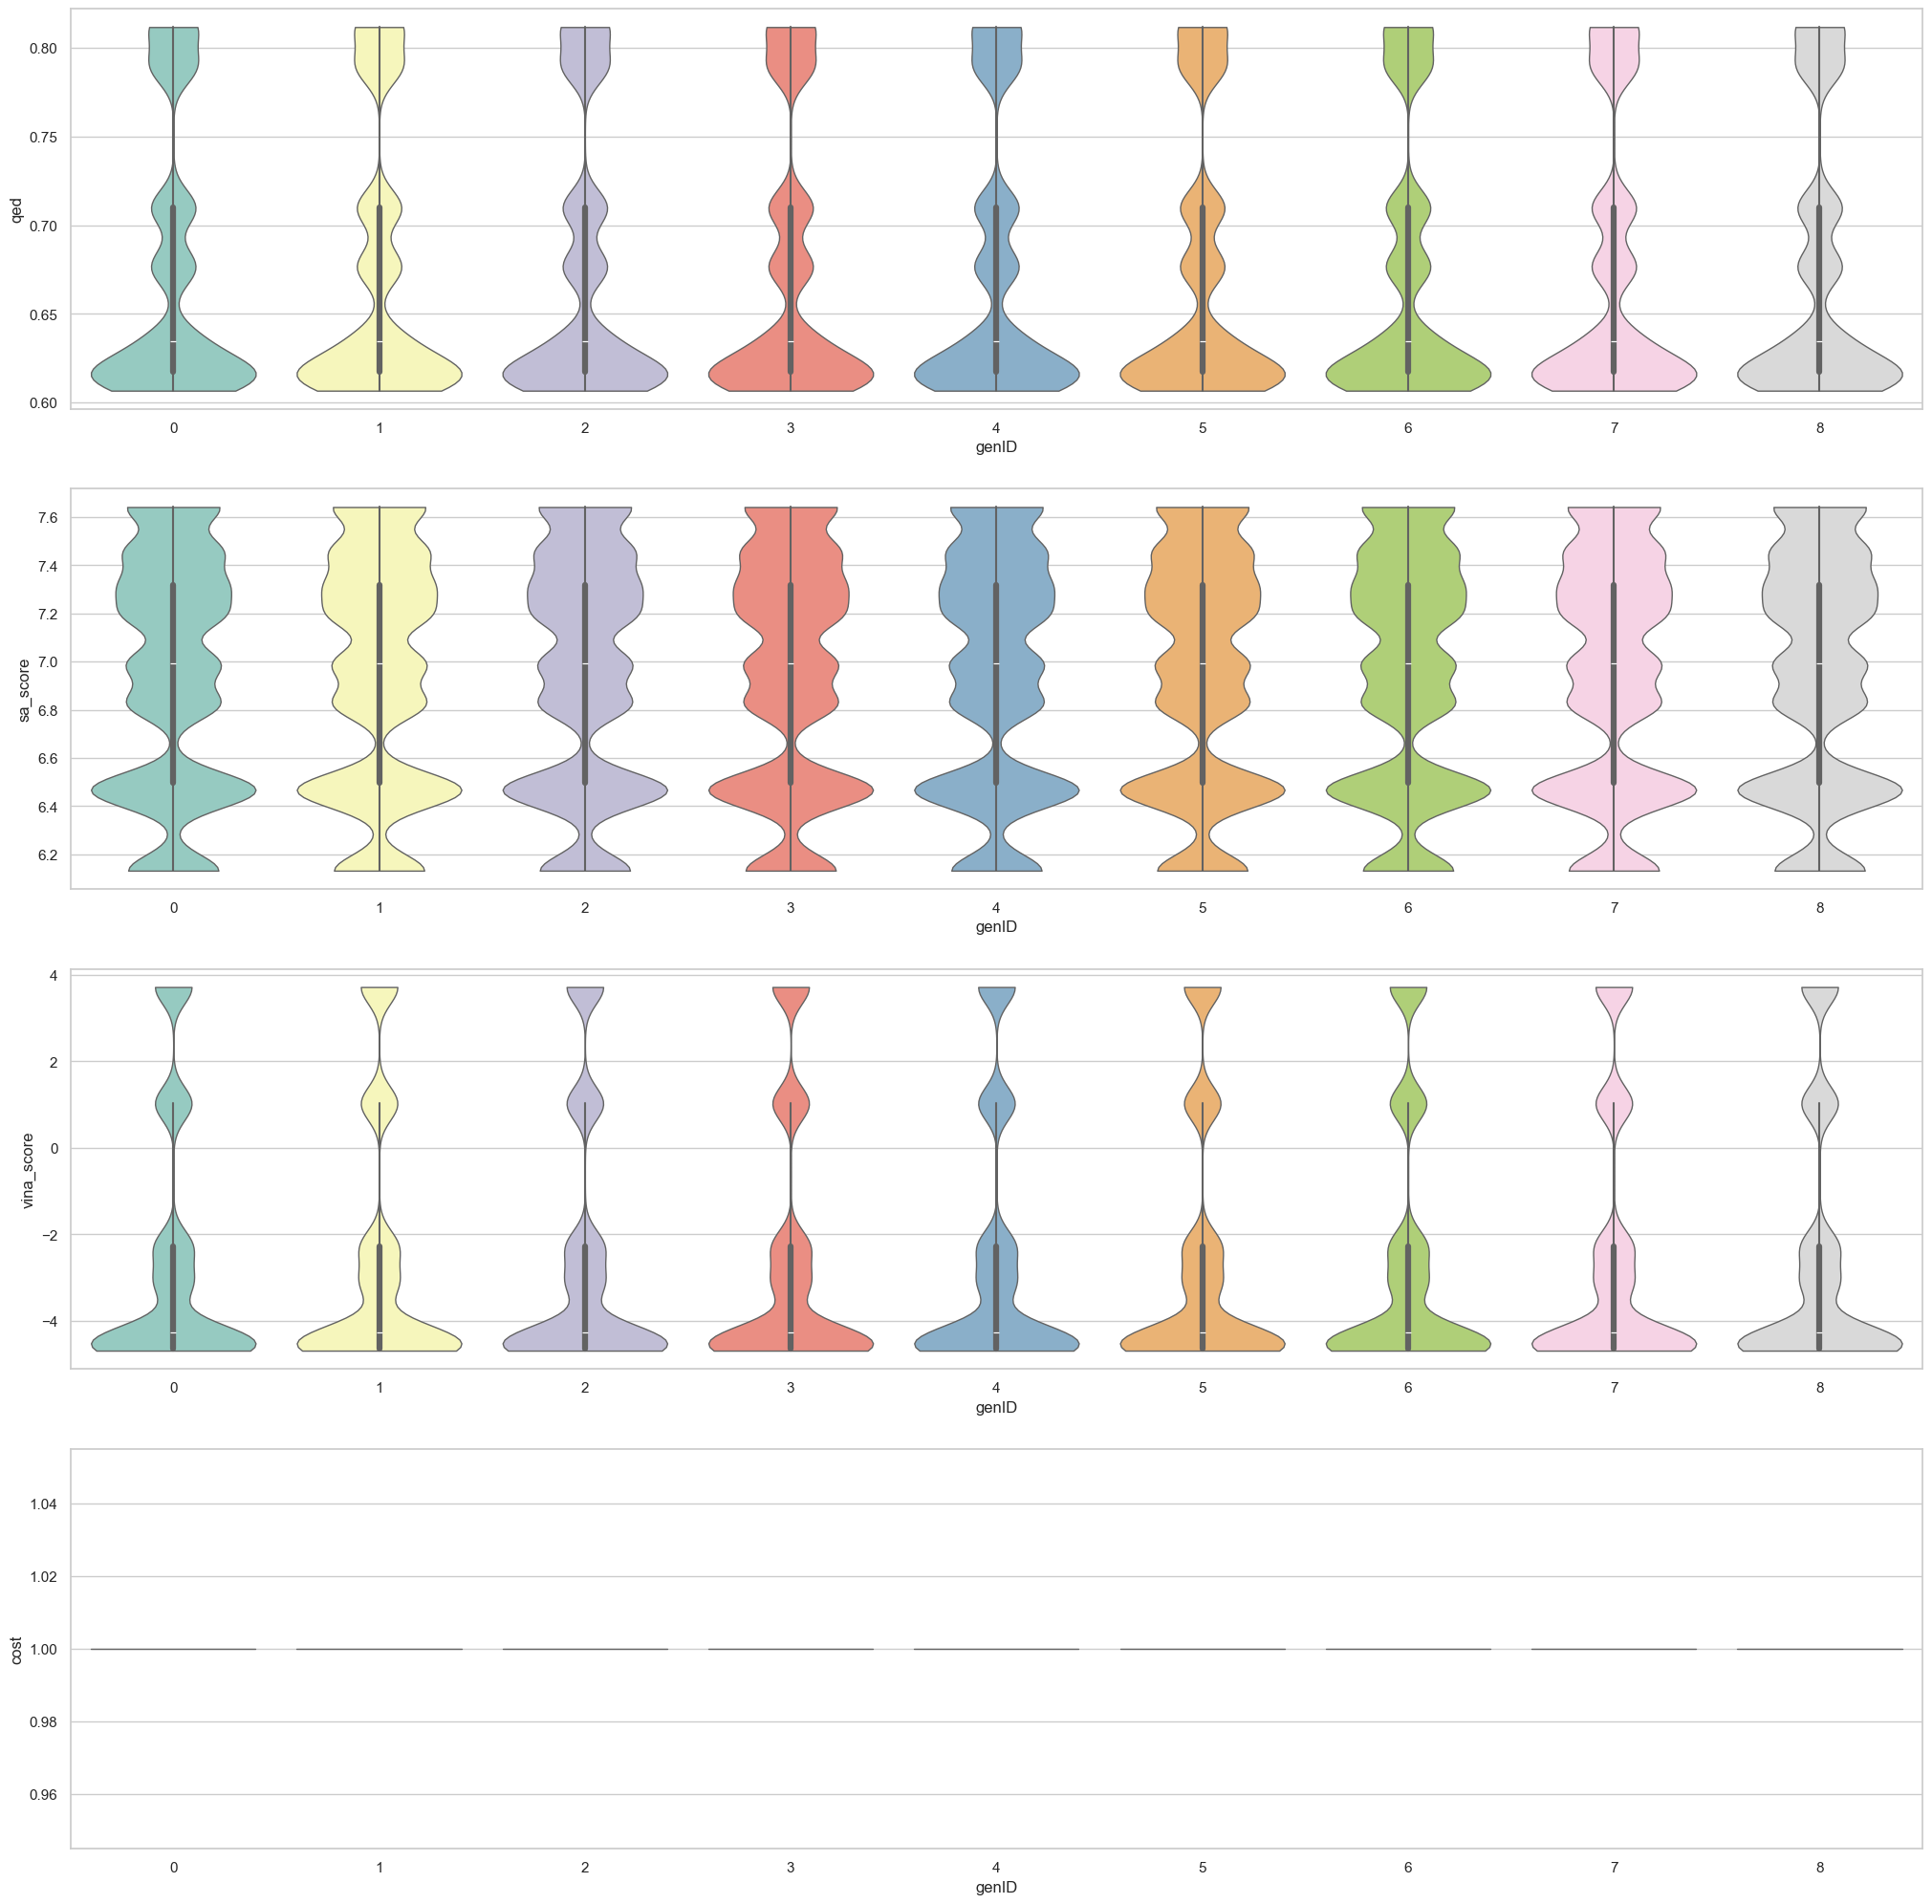

In [19]:
result = utils.decompress_pickle(os.path.join(wd, '04_local_result.pbz2'))
plot_dist(result.SawIndividuals, properties=['qed', 'sa_score', 'vina_score', 'cost'])

## See how it looks with local_only

In [15]:
# Save the new config as a yaml file
new_config = config.copy()
new_config['01_grow']['costfunc_kwargs']['constraint_type'] = 'local_only'

with open(os.path.join(wd, 'new_config.yml'), 'w') as f:
    yaml.dump(config, f)
os.listdir(wd)

['02_allow_grow_pop.sdf',
 '04_local_pop.sdf',
 'new_config.yml',
 '01_grow_result.pbz2',
 'x0161.pdbqt',
 '03_pure_mutate_pop.sdf',
 '04_local_result.pbz2',
 '01_grow_pop.sdf',
 '03_pure_mutate_result.pbz2',
 'crem.db.gz',
 '03_pure_mutate_pop.pbz2',
 'ref.sdf',
 'config.yml',
 '02_allow_grow_result.pbz2',
 'crem.db',
 '01_grow_pop.pbz2',
 '02_allow_grow_pop.pbz2',
 '04_local_pop.pbz2',
 'x0161.pdb']

## Move back to the directory and run moldrug

In [20]:
cwd = os.getcwd()
os.chdir(wd)
! moldrug new_config.yml
os.chdir(cwd)
os.listdir(wd)
os.chdir(cwd)

Started at Fri Oct 27 16:55:04 2023
You are using moldrug: 3.5.0.

CommandLineHelper(yaml_file='new_config.yml', fitness=None, outdir=None, continuation=False)




Creating the first population with 10 members:
100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.48s/it]
Initial Population: Best Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Accepted rate: 10 / 10

File 01_grow_pop.sdf was createad!
Evaluating generation 1 / 2:
100%|█████████████████████████████████████████████| 5/5 [01:30<00:00, 18.06s/it]
Generation 1: Best Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0).
Accepted rate: 0 / 5

Evaluating generation 2 / 2:
100%|█████████████████████████████████████████████| 5/5 [01:17<00:00, 15.59s/it]
File 01_grow_pop.sdf was createad!
Generation 2: Best Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0).
Accepted rate: 0 / 5


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

In [21]:
# parms = pmd.rdkit.from_sdf(os.path.join(wd, '04_local_pop.sdf')) # require parmed, rdkit
# parms

In [22]:
# view = nv.NGLWidget()

# slider = IntSlider(max=len(parms)-1)

# def show_one_ligand(change):
#     val = change['new']
#     view.show_only([val])
    
# slider.observe(show_one_ligand, 'value')

# VBox([view, slider])

In [23]:
# for p in parms:
#     view.add_structure(nv.ParmEdTrajectory(p))
# view.show_only([0])

(<Figure size 2500x2500 with 4 Axes>,
 array([<Axes: xlabel='genID', ylabel='qed'>,
        <Axes: xlabel='genID', ylabel='sa_score'>,
        <Axes: xlabel='genID', ylabel='vina_score'>,
        <Axes: xlabel='genID', ylabel='cost'>], dtype=object))

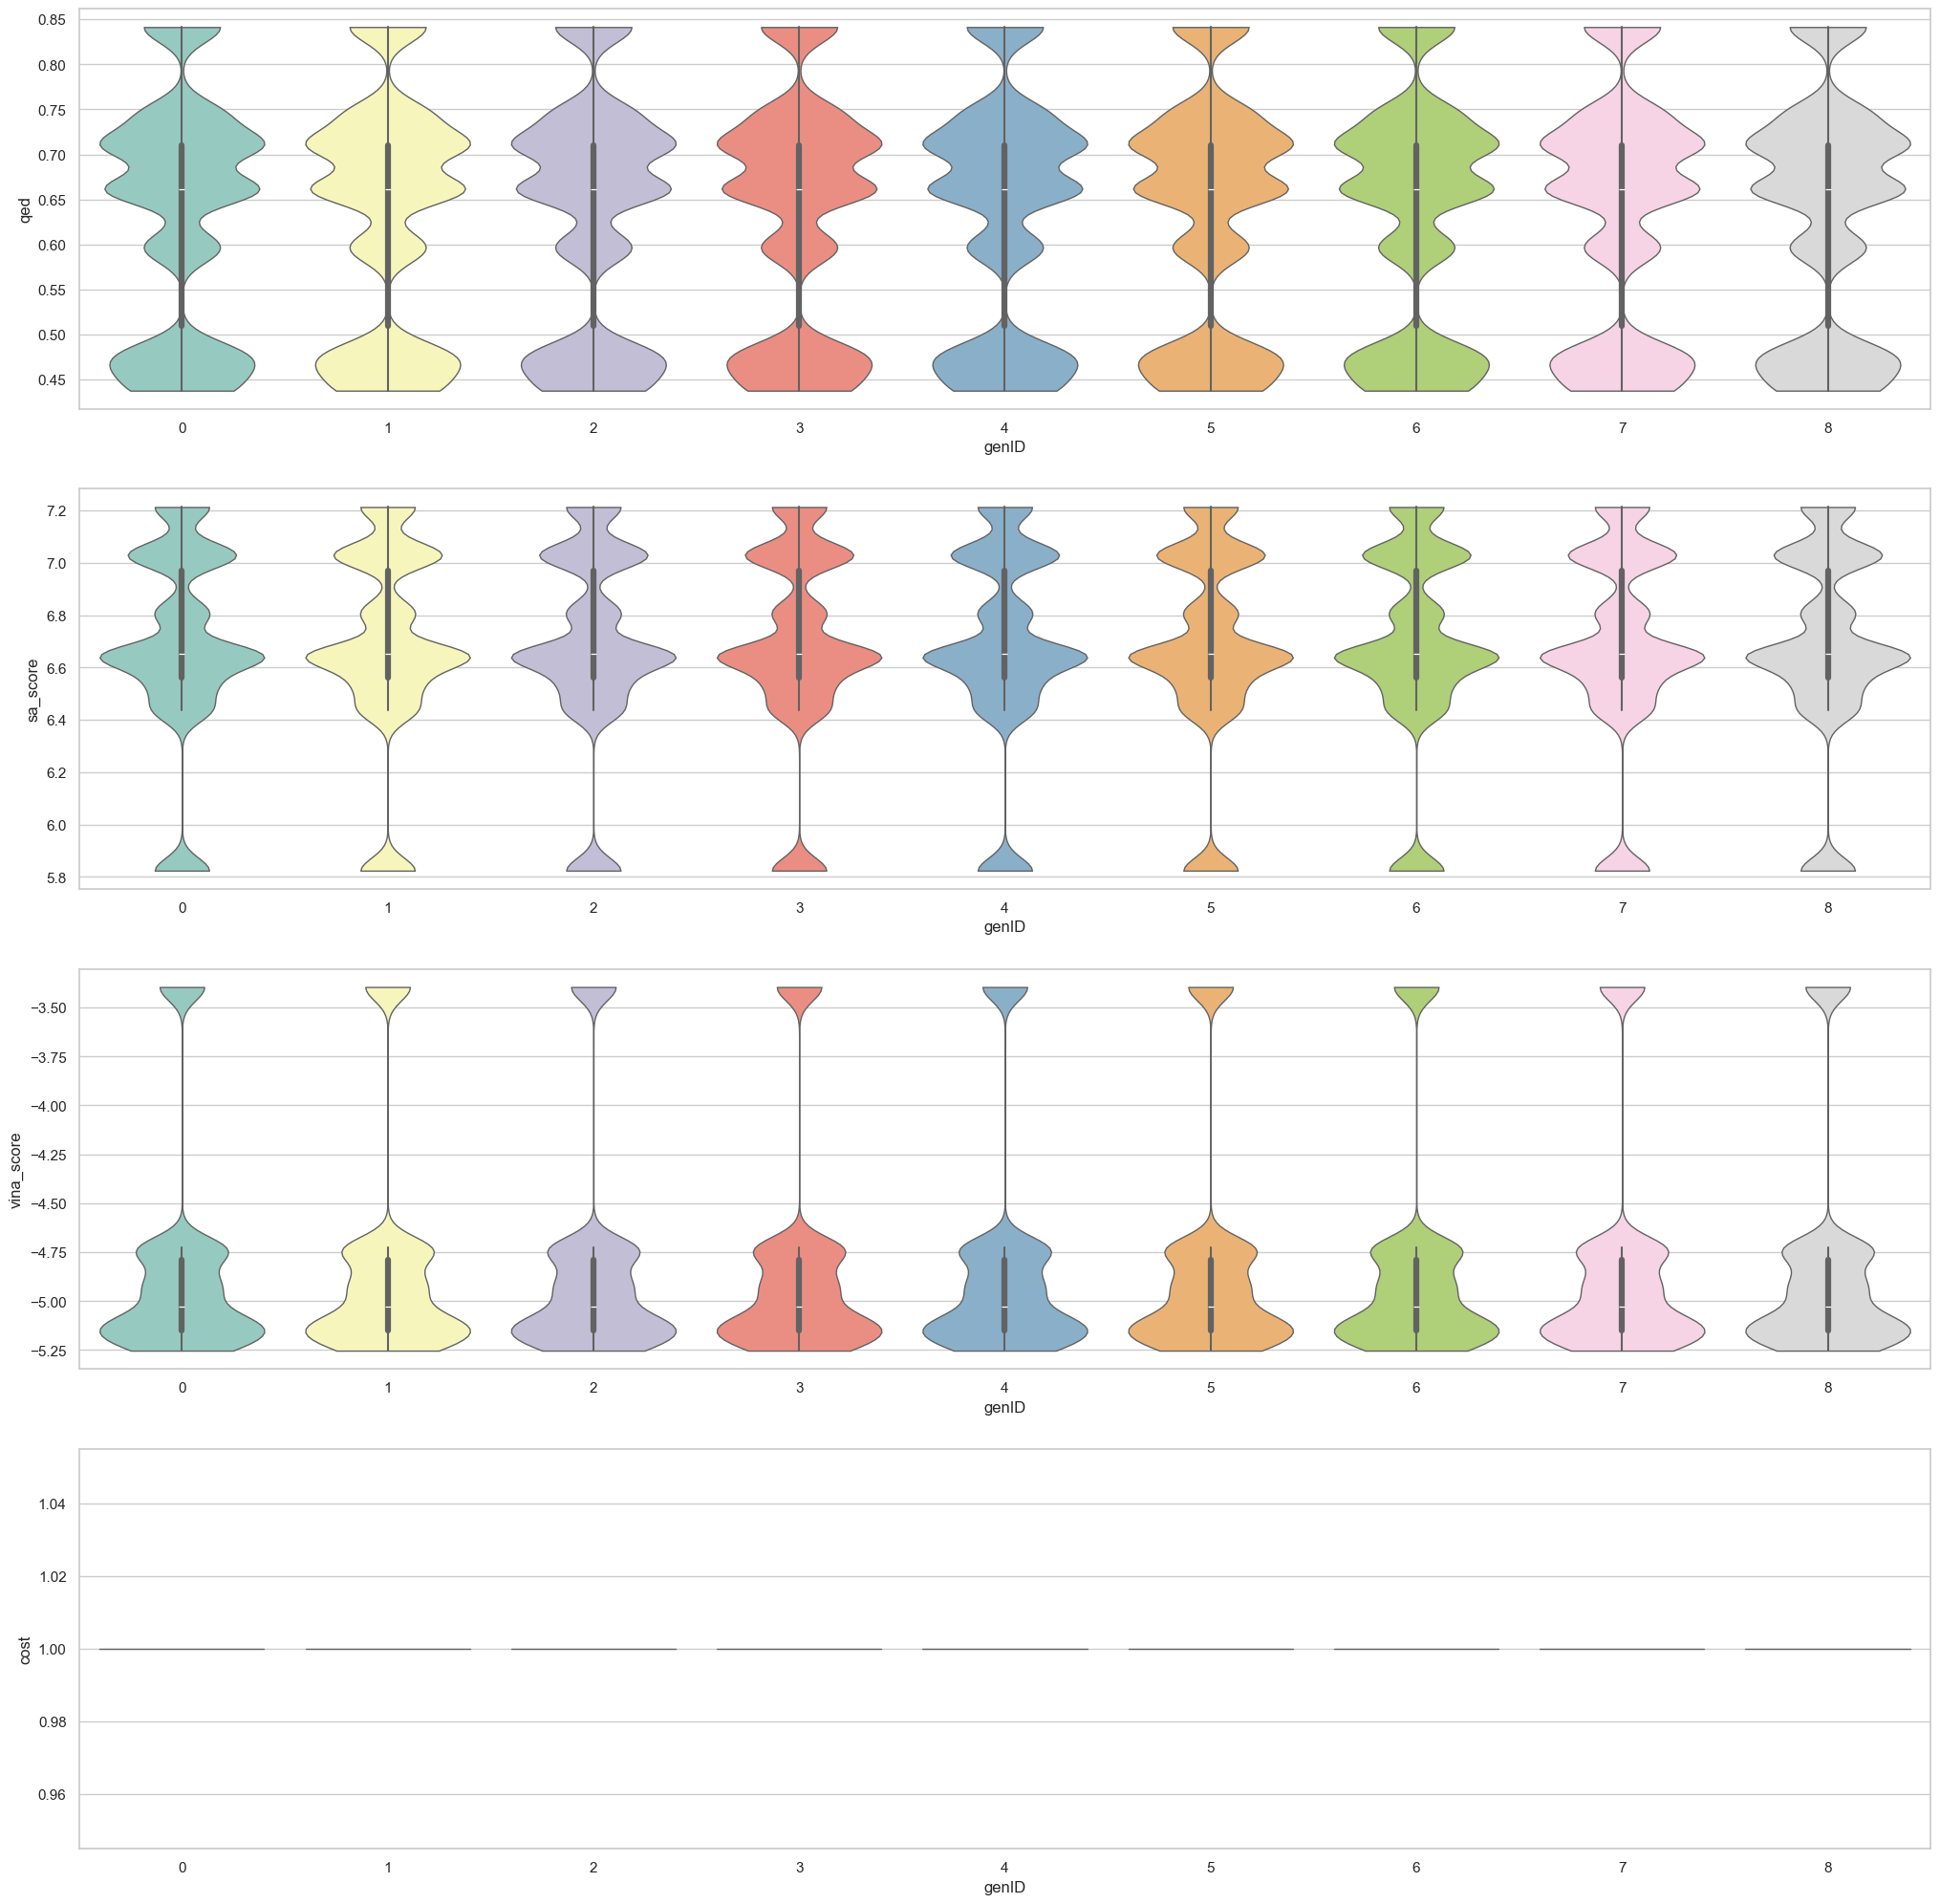

In [24]:
result = utils.decompress_pickle(os.path.join(wd, '04_local_result.pbz2'))
plot_dist(result.SawIndividuals, properties=['qed', 'sa_score', 'vina_score', 'cost'])


On both examples **MolDrug** can not optimize the cost function. The population does not change. One of the main cause of this behavior is the desirability definition used for vina_score:

```
'vina_score': {
    'w': 1,
    'SmallerTheBest': {
        'Target': -12,
        'UpperLimit': -6,
        'r': 1
    }
}
```

This means that if the vina score is not lower than -6 the cost function will be always 1. In this scenario all were are not optimizing over the generations the "best" individuals. In other words, it is important to see what is the behavior of our system (one small simulation) and then tune your parameters accordantly. On possibility for this system is change UpperLimit to, for example -4. There are a lot of other different options that you could play around (e.g. increase the generations, etc...). It is important to remark that this example is just for the tutorial, in a real project you may need to increase generations, tune the crem keywords, etc. I let it to you as a challenge. Happy simulations!

Just as a bonus I let you here how to change the desirability definition.

## Change the desirability

In [25]:
# Save the new config as a yaml file
tune_config = new_config.copy()
tune_config['01_grow']['costfunc_kwargs']['desirability'] = {
        'qed': {
            'w': 1,
            'LargerTheBest': {
                'LowerLimit': 0.1,
                'Target': 0.75,
                'r': 1
            }
        },
        'sa_score': {
            'w': 1,
            'SmallerTheBest': {
                'Target': 3,
                'UpperLimit': 7,
                'r': 1
            }
        },
        'vina_score': {
            'w': 1,
            'SmallerTheBest': {
                'Target': -9,
                'UpperLimit': -4,
                'r': 1
            }
        }
    }

with open(os.path.join(wd, 'tune_config.yml'), 'w') as f:
    yaml.dump(config, f)
os.listdir(wd)


['02_allow_grow_pop.sdf',
 '04_local_pop.sdf',
 'new_config.yml',
 '01_grow_result.pbz2',
 'x0161.pdbqt',
 '03_pure_mutate_pop.sdf',
 '04_local_result.pbz2',
 '01_grow_pop.sdf',
 '03_pure_mutate_result.pbz2',
 'crem.db.gz',
 '03_pure_mutate_pop.pbz2',
 'tune_config.yml',
 'ref.sdf',
 'config.yml',
 'error.tar.gz',
 '02_allow_grow_result.pbz2',
 'crem.db',
 '01_grow_pop.pbz2',
 '02_allow_grow_pop.pbz2',
 '04_local_pop.pbz2',
 'x0161.pdb']

In [26]:

cwd = os.getcwd()
os.chdir(wd)
! moldrug tune_config.yml
os.chdir(cwd)
os.listdir(wd)
os.chdir(cwd)

Started at Fri Oct 27 17:04:34 2023
You are using moldrug: 3.5.0.

CommandLineHelper(yaml_file='tune_config.yml', fitness=None, outdir=None, continuation=False)




Creating the first population with 10 members:
100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]
Initial Population: Best Individual: Individual(idx = 5, smiles = COC(=O)c1ccc(S(=O)(=O)Nn2cnnc2)cc1, cost = 0.6939256638901279)
Accepted rate: 10 / 10

File 01_grow_pop.sdf was createad!
Evaluating generation 1 / 2:
100%|█████████████████████████████████████████████| 5/5 [01:01<00:00, 12.35s/it]
Generation 1: Best Individual: Individual(idx = 5, smiles = COC(=O)c1ccc(S(=O)(=O)Nn2cnnc2)cc1, cost = 0.6939256638901279).
Accepted rate: 3 / 5

Evaluating generation 2 / 2:
100%|█████████████████████████████████████████████| 4/4 [01:13<00:00, 18.43s/it]
File 01_grow_pop.sdf was createad!
Generation 2: Best Individual: Individual(idx = 15, smiles = N#CCCOC(=O)c1ccc(S(N)(=O)=O)cc1C#N, cost = 0.673756810809

(<Figure size 2500x2500 with 4 Axes>,
 array([<Axes: xlabel='genID', ylabel='qed'>,
        <Axes: xlabel='genID', ylabel='sa_score'>,
        <Axes: xlabel='genID', ylabel='vina_score'>,
        <Axes: xlabel='genID', ylabel='cost'>], dtype=object))

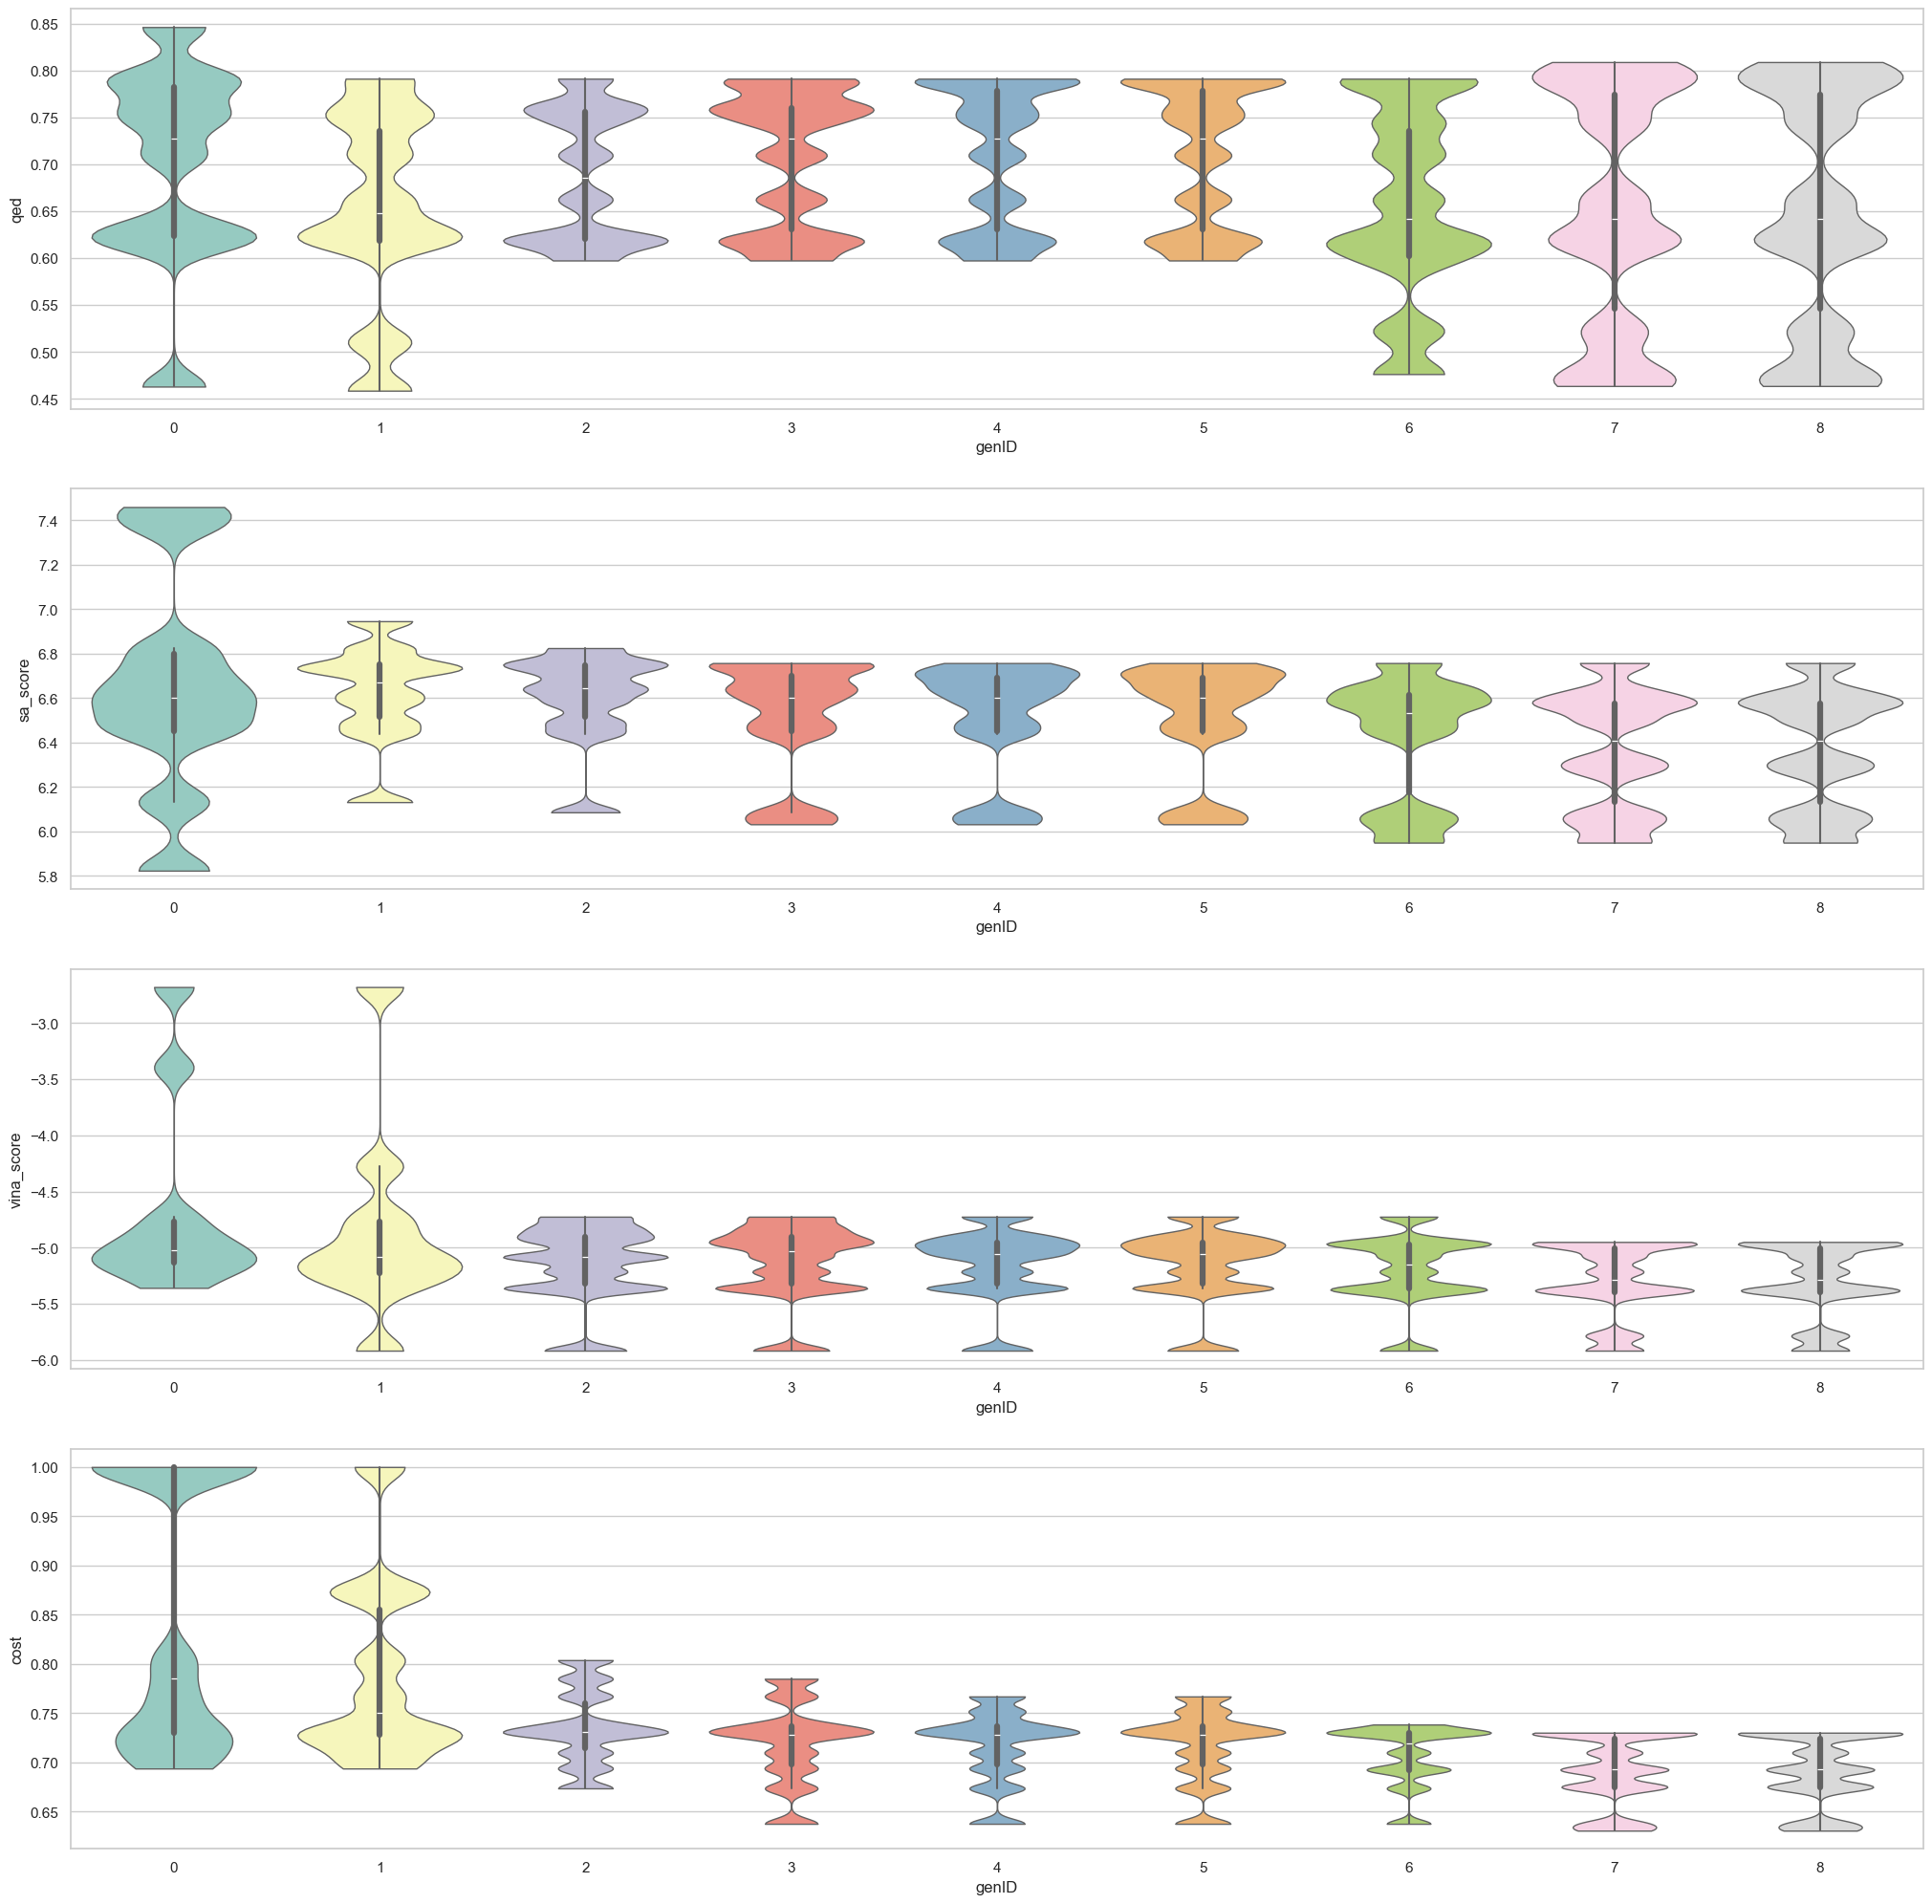

In [27]:
result = utils.decompress_pickle(os.path.join(wd, '04_local_result.pbz2'))
plot_dist(result.SawIndividuals, properties=['qed', 'sa_score', 'vina_score', 'cost'])


Now we see  completely different picture. The optimization is working again! You can see how the `Accepted rate` is not always cero over the different generations, this mean that the population is changing. So, we get some improvements changing the desirability ;-).

Take home message: Different consecutive runs with different desirability may help to get out from the local minimum of the initial population.